In [1]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum

fatal: destination path 'Transformer-MM-Explainability' already exists and is not an empty directory.


In [2]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization
import random
from tqdm import tqdm
import pandas as pd
import json
import math

/home/hlpark/miniconda3/envs/hirest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [4]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last layer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1: 
      # calculate index of last layer 
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

In [5]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [6]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [7]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

/home/hlpark/miniconda3/envs/hirest/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [9]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [10]:
def get_frame_number(filename):
    # This extracts numbers from a filename like 'frame_00001.jpg'
    return int(filename.replace('frame_', '').replace('.jpg', ''))

In [11]:
def save_json(content, save_path):
    with open(save_path, 'w') as f:
        f.write(json.dumps(content))
def load_jsonl(filename):
    with open(filename, "r") as f:
        return [json.loads(l.strip("\n")) for l in f.readlines()]

In [12]:
random.seed(10)
extract_from_full=True
if extract_from_full:
    file_dict = {'image_path':[], 'video':[] }
    
    for root, dirs, files in os.walk("/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames"):
        for dir in dirs:
            for r, d, file in os.walk(os.path.join(root, dir)):
                file_dict['image_path'].append(os.path.join(r, file[random.randrange(len(file))])) 
                file_dict['video'].append(dir)
else:
    file_dict = {'image_path':[], 'video':[], 'query':[] }
    val_path = '/home/hlpark/shared/TVQA/tvqa_qa_release/tvqa_val.jsonl'
    test_path = '/home/hlpark/shared/TVQA/tvqa_qa_release/tvqa_test_public.jsonl'
    vid_duration_json = "/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/video_duration.json"
    val = load_jsonl(val_path)
    test = load_jsonl(test_path)
    vid_duration = load_jsonl(vid_duration_json)
    root = "/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames"
    for idx, v in enumerate(val):
        filenames = os.listdir(os.path.join(root, v['vid_name'] +  ".mp4"))
        sorted_filenames = sorted(filenames, key=get_frame_number)
        #print(sorted_filenames)
        if math.isnan(float(v['ts'].split('-')[0])) or math.isnan(float(v['ts'].split('-')[1])):
            k = random.randint(0, len(filenames) - 1)
            # k = len(filenames) // 2
        elif int(float(v['ts'].split('-')[1])) > vid_duration[0][v['vid_name'] + ".mp4"] or int(float(v['ts'].split('-')[0])) > vid_duration[0][v['vid_name'] + ".mp4"]:
            print(f"TIMESTAMP ERROR in original json {v['vid_name']} with video length {vid_duration[0][v['vid_name'] + '.mp4']}: {v['ts']}")
            k = random.randint(0, len(filenames) - 1)
        else:
            k = random.randint(int(float(v['ts'].split('-')[0])), int(float(v['ts'].split('-')[1])))
            #k = (int(float(v['ts'].split('-')[0])) + int(float(v['ts'].split('-')[1]))) // 2
        #print(vid_duration[0][v['vid_name'] + ".mp4"],v['vid_name'], len(sorted_filenames), k, v['ts'])
        file_dict['image_path'].append(os.path.join(root, v['vid_name'] +  '.mp4', sorted_filenames[k]))
        file_dict['video'].append(v['vid_name'])
        file_dict['query'].append(v['q'])
        
    for idx, v in enumerate(test):
        filenames = os.listdir(os.path.join(root, v['vid_name'] +  ".mp4"))
        sorted_filenames = sorted(filenames, key=get_frame_number)
        #print(sorted_filenames)
        if math.isnan(float(v['ts'].split('-')[0])) or math.isnan(float(v['ts'].split('-')[1])):
            k = random.randint(0, len(filenames) - 1)
            #k = len(filenames) // 2
        elif int(float(v['ts'].split('-')[1])) > vid_duration[0][v['vid_name'] + ".mp4"] or int(float(v['ts'].split('-')[0])) > vid_duration[0][v['vid_name'] + ".mp4"]:
            print(f"TIMESTAMP ERROR in original json {v['vid_name']} with video length {vid_duration[0][v['vid_name'] + '.mp4']}: {v['ts']}")
            k = random.randint(0, len(filenames) - 1)
        else:
            k = random.randint(int(float(v['ts'].split('-')[0])), int(float(v['ts'].split('-')[1])))
            #k = (int(float(v['ts'].split('-')[0])) + int(float(v['ts'].split('-')[1]))) // 2
        file_dict['image_path'].append(os.path.join(root, v['vid_name'] +  ".mp4", sorted_filenames[k]))
        file_dict['video'].append(v['vid_name'])
        file_dict['query'].append(v['q'])
        
                


In [13]:
data = pd.DataFrame.from_dict(file_dict)

In [17]:
#randomly select from each folder and get original image path
five_label_root = "/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/evaluation/analysis/five_label_classification_images"

random.seed(13)

selected_images = {}
for r, dirs, files in os.walk(five_label_root):
    for dir in dirs:
        for _, d, file in os.walk(os.path.join(r, dir)):
            images = [img.replace(".mp4.jpg", "") for img in random.sample(file, 2)]
            for i, x in data.iterrows():
                if images[0] in x['image_path']:
                    images[0] = x['image_path']
                elif images[1] in x['image_path']:
                    images[1] = x['image_path']
            selected_images[dir.split("_")[-1]] = images

print(selected_images)



{'mnm': ['/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/house_s04e13_seg02_clip_01.mp4/frame_000064.jpg', '/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/house_s02e13_seg02_clip_18.mp4/frame_000060.jpg'], 'mm': ['/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/house_s02e10_seg02_clip_24.mp4/frame_000045.jpg', '/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/house_s08e16_seg02_clip_13.mp4/frame_000007.jpg'], 'nmm': ['/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/s04e13_seg02_clip_12.mp4/frame_000005.jpg', '/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/friends_s03e21_seg02_clip_01.mp4/frame_000019.jpg'], 'nmnm': ['/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/castle_s02e07_seg02_clip_10.mp4/frame_000006.jpg', '/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/s10e04_seg02_clip_14.mp4/

medical TV show predicted as medical video
CLIP similarity score: 0.6259765625
tensor([0.2612, 0.3193, 0.1135, 0.3062], device='cuda:0', dtype=torch.float16)


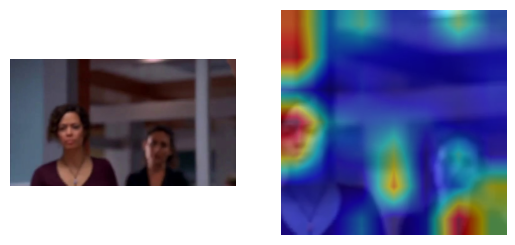

CLIP similarity score: 0.2822265625
tensor([0.0609, 0.1068, 0.1075, 0.7251], device='cuda:0', dtype=torch.float16)


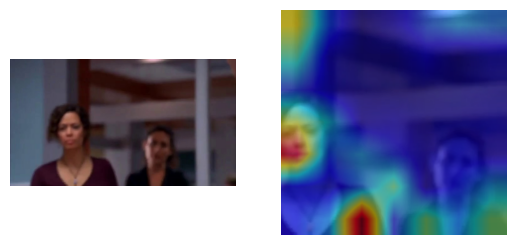

CLIP similarity score: 0.033721923828125
tensor([0.0693, 0.0291, 0.0358, 0.8652], device='cuda:0', dtype=torch.float16)


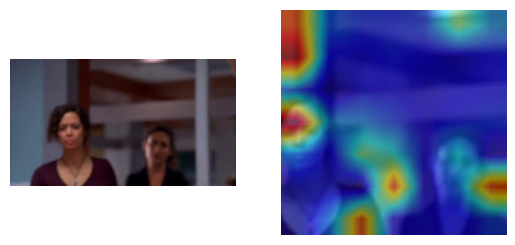

CLIP similarity score: 0.01593017578125
tensor([0.1694, 0.1177, 0.0568, 0.6558], device='cuda:0', dtype=torch.float16)


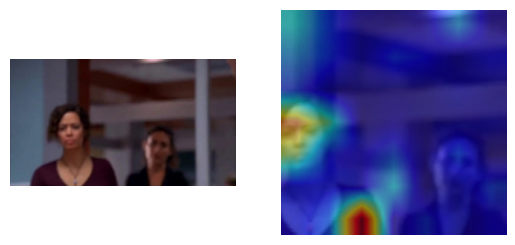

CLIP similarity score: 0.041961669921875
tensor([0.1338, 0.1561, 0.1747, 0.5356], device='cuda:0', dtype=torch.float16)


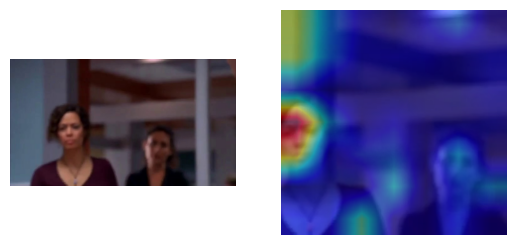

medical TV show predicted as medical video
CLIP similarity score: 0.9619140625
tensor([0.1036, 0.0331, 0.0094, 0.8535], device='cuda:0', dtype=torch.float16)


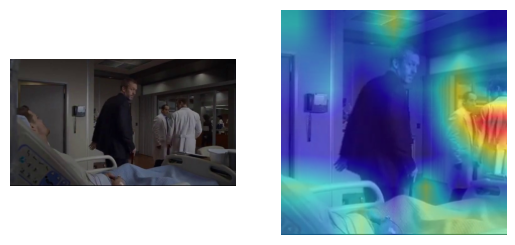

CLIP similarity score: 0.01934814453125
tensor([0.4685, 0.1639, 0.0733, 0.2939], device='cuda:0', dtype=torch.float16)


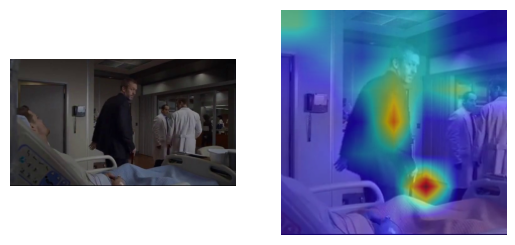

CLIP similarity score: 0.000492095947265625
tensor([0.2325, 0.0955, 0.0144, 0.6577], device='cuda:0', dtype=torch.float16)


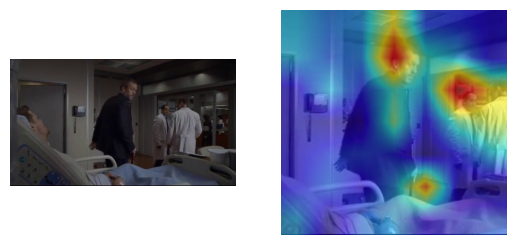

CLIP similarity score: 0.001491546630859375
tensor([0.3313, 0.1105, 0.0172, 0.5410], device='cuda:0', dtype=torch.float16)


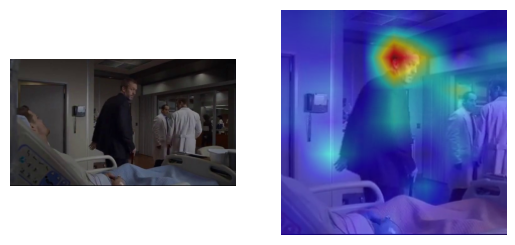

CLIP similarity score: 0.016815185546875
tensor([0.5195, 0.0895, 0.1052, 0.2859], device='cuda:0', dtype=torch.float16)


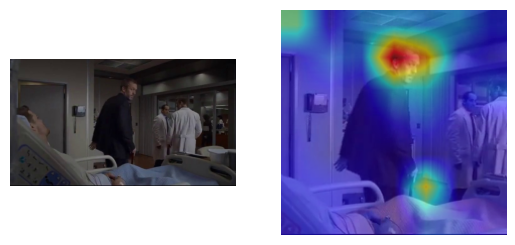

In [19]:
img_path = selected_images['mm'][0]
image_input = preprocess(Image.open(img_path).convert("RGB"))
img = image_input.unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a school", "This is a outside", "This is a home"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
probs = logits_per_image.softmax(dim=-1)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print("medical TV show predicted as medical video")
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()
img_path = selected_images['mm'][1]
image_input = preprocess(Image.open(img_path).convert("RGB"))
img = image_input.unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a school", "This is a outside", "This is a home"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
probs = logits_per_image.softmax(dim=-1)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print("medical TV show predicted as medical video")
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()


medical TV show predicted as non-medical video
CLIP similarity score: 0.066650390625
tensor([0.1678, 0.3298, 0.2913, 0.2112], device='cuda:0', dtype=torch.float16)


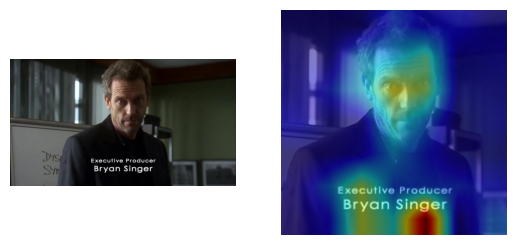

CLIP similarity score: 0.8779296875
tensor([0.0554, 0.1293, 0.3589, 0.4561], device='cuda:0', dtype=torch.float16)


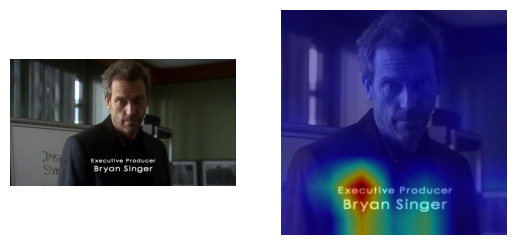

CLIP similarity score: 0.018218994140625
tensor([0.0280, 0.1026, 0.0899, 0.7793], device='cuda:0', dtype=torch.float16)


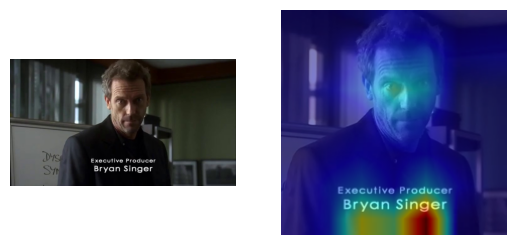

CLIP similarity score: 0.00860595703125
tensor([0.0563, 0.0867, 0.1338, 0.7231], device='cuda:0', dtype=torch.float16)


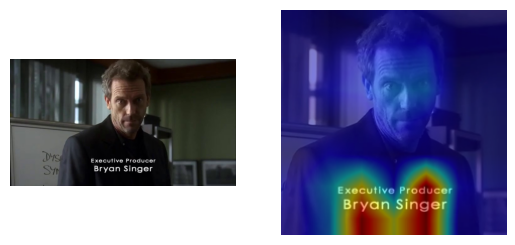

CLIP similarity score: 0.028656005859375
tensor([0.0632, 0.0602, 0.3481, 0.5283], device='cuda:0', dtype=torch.float16)


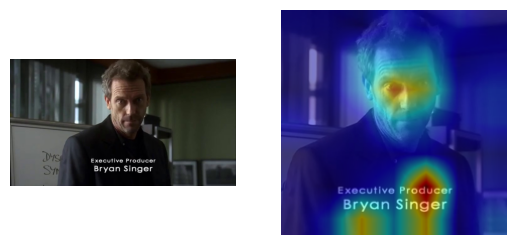

medical TV show predicted as non-medical video
CLIP similarity score: 0.37255859375
tensor([0.1437, 0.0986, 0.0823, 0.6753], device='cuda:0', dtype=torch.float16)


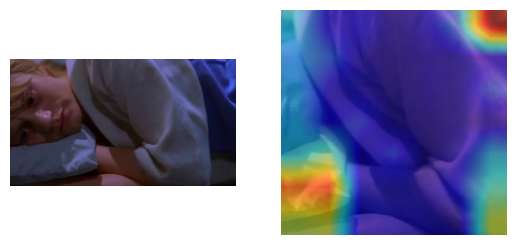

CLIP similarity score: 0.0330810546875
tensor([0.3691, 0.1884, 0.1284, 0.3142], device='cuda:0', dtype=torch.float16)


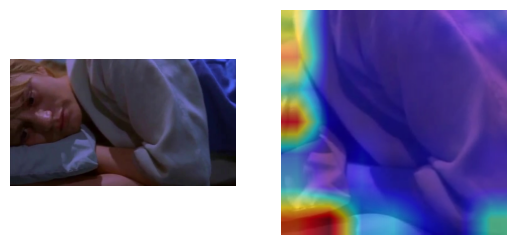

CLIP similarity score: 0.0216827392578125
tensor([0.2487, 0.1699, 0.1263, 0.4551], device='cuda:0', dtype=torch.float16)


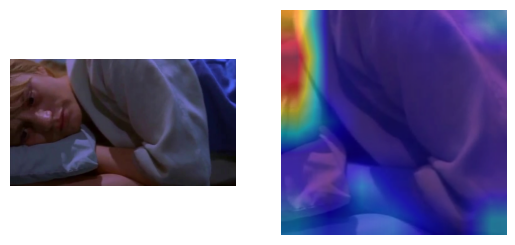

CLIP similarity score: 0.055389404296875
tensor([0.2590, 0.1418, 0.0873, 0.5122], device='cuda:0', dtype=torch.float16)


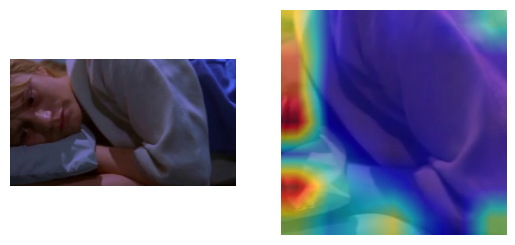

CLIP similarity score: 0.51708984375
tensor([0.2489, 0.1205, 0.1092, 0.5210], device='cuda:0', dtype=torch.float16)


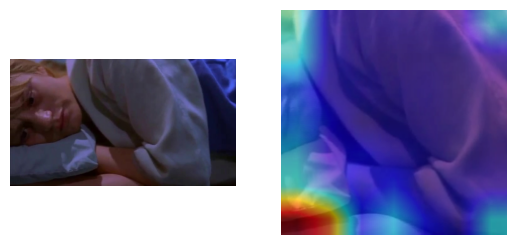

In [20]:
img_path = selected_images['mnm'][0]
image_input = preprocess(Image.open(img_path).convert("RGB"))
img = image_input.unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a school", "This is a outside", "This is a home"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
probs = logits_per_image.softmax(dim=-1)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print("medical TV show predicted as non-medical video")
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()
img_path = selected_images['mnm'][1]
image_input = preprocess(Image.open(img_path).convert("RGB"))
img = image_input.unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a school", "This is a outside", "This is a home"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
probs = logits_per_image.softmax(dim=-1)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print("medical TV show predicted as non-medical video")
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

non-medical TV show predicted as medical video
CLIP similarity score: 0.53662109375
tensor([0.1052, 0.0511, 0.0698, 0.7739], device='cuda:0', dtype=torch.float16)


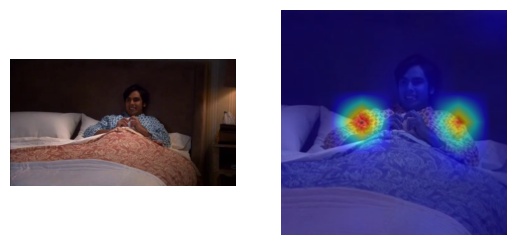

CLIP similarity score: 0.105712890625
tensor([0.3655, 0.0610, 0.1313, 0.4424], device='cuda:0', dtype=torch.float16)


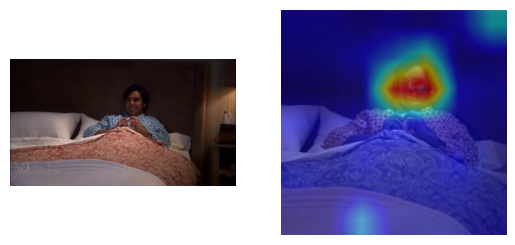

CLIP similarity score: 0.0022983551025390625
tensor([0.1310, 0.0701, 0.1198, 0.6787], device='cuda:0', dtype=torch.float16)


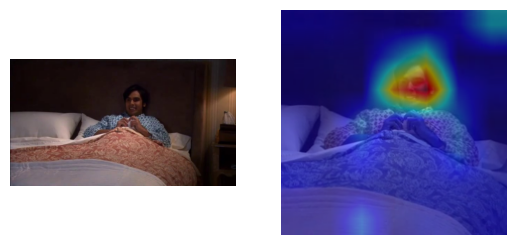

CLIP similarity score: 0.019256591796875
tensor([0.2354, 0.0604, 0.0684, 0.6357], device='cuda:0', dtype=torch.float16)


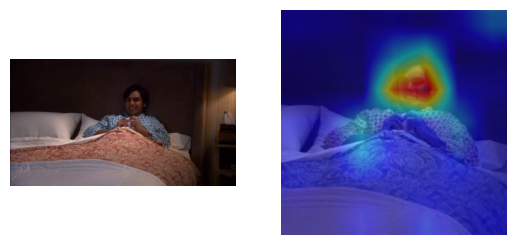

CLIP similarity score: 0.3359375
tensor([0.1549, 0.0218, 0.0526, 0.7705], device='cuda:0', dtype=torch.float16)


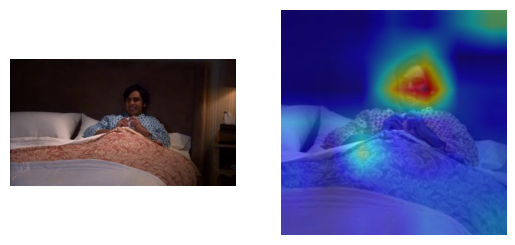

non-medical TV show predicted as medical video
CLIP similarity score: 0.397216796875
tensor([0.0249, 0.0640, 0.0122, 0.8989], device='cuda:0', dtype=torch.float16)


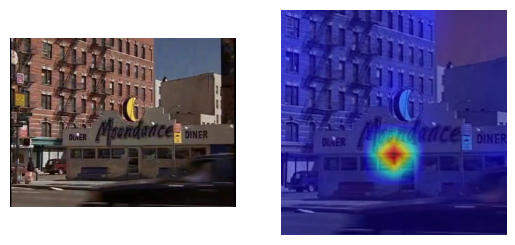

CLIP similarity score: 0.2335205078125
tensor([0.4302, 0.3972, 0.0927, 0.0798], device='cuda:0', dtype=torch.float16)


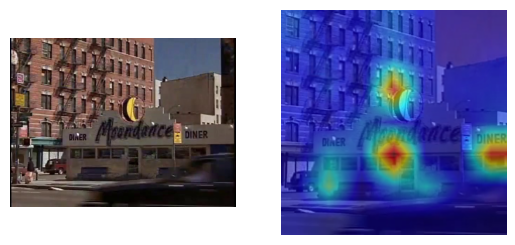

CLIP similarity score: 0.01074981689453125
tensor([0.0343, 0.0571, 0.0052, 0.9038], device='cuda:0', dtype=torch.float16)


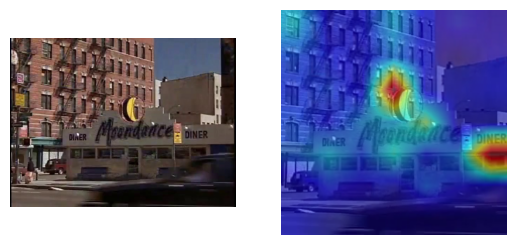

CLIP similarity score: 0.06793212890625
tensor([0.0719, 0.0613, 0.0162, 0.8506], device='cuda:0', dtype=torch.float16)


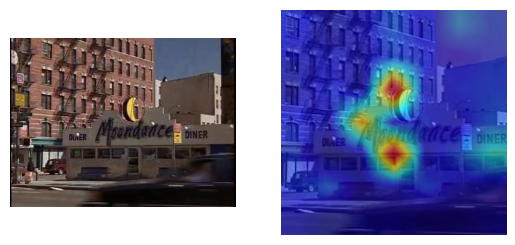

CLIP similarity score: 0.29052734375
tensor([0.0561, 0.3774, 0.0717, 0.4949], device='cuda:0', dtype=torch.float16)


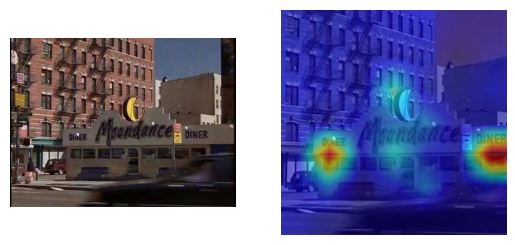

In [21]:
img_path = selected_images['nmm'][0]
image_input = preprocess(Image.open(img_path).convert("RGB"))
img = image_input.unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a school", "This is a outside", "This is a home"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
probs = logits_per_image.softmax(dim=-1)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print("non-medical TV show predicted as medical video")
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()
img_path = selected_images['nmm'][1]
image_input = preprocess(Image.open(img_path).convert("RGB"))
img = image_input.unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a school", "This is a outside", "This is a home"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
probs = logits_per_image.softmax(dim=-1)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print("non-medical TV show predicted as medical video")
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

non-medical TV show predicted as non-medical video
CLIP similarity score: 0.263916015625
tensor([0.0624, 0.3811, 0.1533, 0.4033], device='cuda:0', dtype=torch.float16)


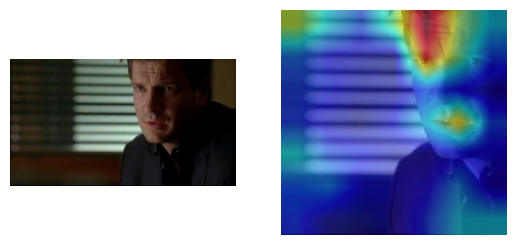

CLIP similarity score: 0.3134765625
tensor([0.0066, 0.1603, 0.0676, 0.7651], device='cuda:0', dtype=torch.float16)


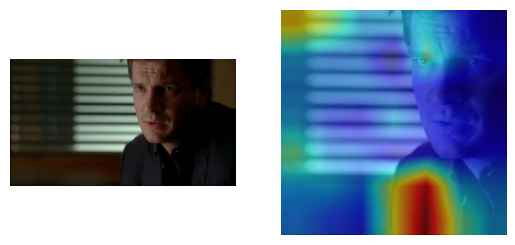

CLIP similarity score: 0.0245513916015625
tensor([0.0376, 0.1132, 0.0844, 0.7651], device='cuda:0', dtype=torch.float16)


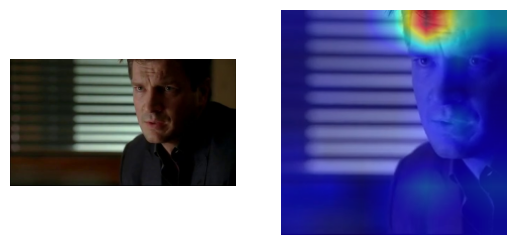

CLIP similarity score: 0.031524658203125
tensor([0.1050, 0.3735, 0.1799, 0.3416], device='cuda:0', dtype=torch.float16)


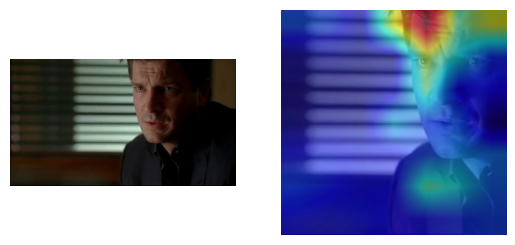

CLIP similarity score: 0.366455078125
tensor([0.0215, 0.2059, 0.0746, 0.6978], device='cuda:0', dtype=torch.float16)


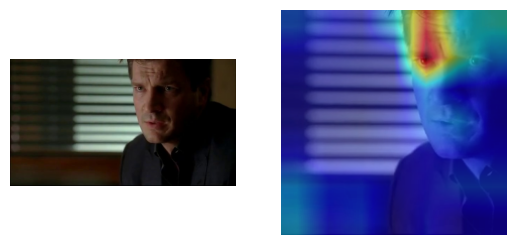

non-medical TV show predicted as non-medical video
CLIP similarity score: 0.1275634765625
tensor([0.2751, 0.1473, 0.0929, 0.4844], device='cuda:0', dtype=torch.float16)


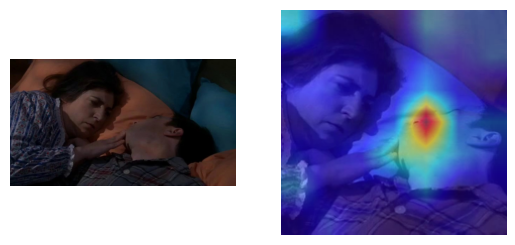

CLIP similarity score: 0.0214691162109375
tensor([0.3469, 0.0979, 0.0822, 0.4729], device='cuda:0', dtype=torch.float16)


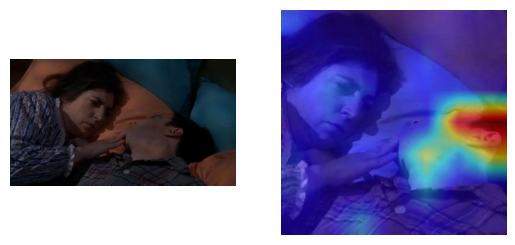

CLIP similarity score: 0.0019359588623046875
tensor([0.1400, 0.0645, 0.0711, 0.7241], device='cuda:0', dtype=torch.float16)


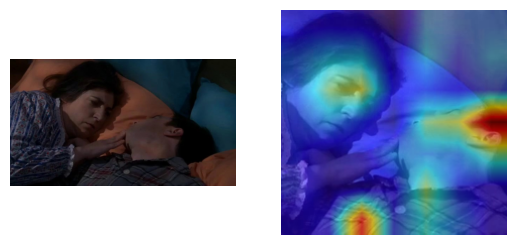

CLIP similarity score: 0.055694580078125
tensor([0.2581, 0.0900, 0.0573, 0.5947], device='cuda:0', dtype=torch.float16)


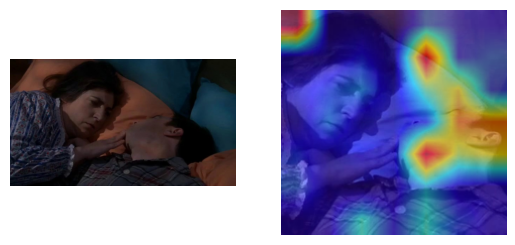

CLIP similarity score: 0.79345703125
tensor([0.3945, 0.2058, 0.0977, 0.3020], device='cuda:0', dtype=torch.float16)


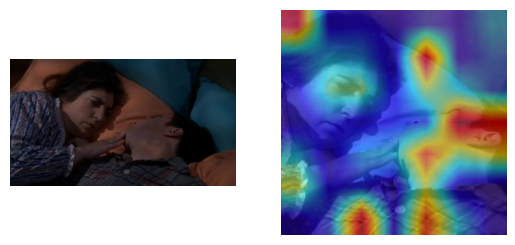

In [23]:
img_path = selected_images['nmnm'][0]
image_input = preprocess(Image.open(img_path).convert("RGB"))
img = image_input.unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a school", "This is a outside", "This is a home"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
probs = logits_per_image.softmax(dim=-1)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print("non-medical TV show predicted as non-medical video")
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()
img_path = selected_images['nmnm'][1]
image_input = preprocess(Image.open(img_path).convert("RGB"))
img = image_input.unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a school", "This is a outside", "This is a home"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
probs = logits_per_image.softmax(dim=-1)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print("non-medical TV show predicted as non-medical video")
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

CLIP similarity score: 0.95947265625
tensor([0.2070, 0.0842, 0.0139, 0.6948], device='cuda:0', dtype=torch.float16)


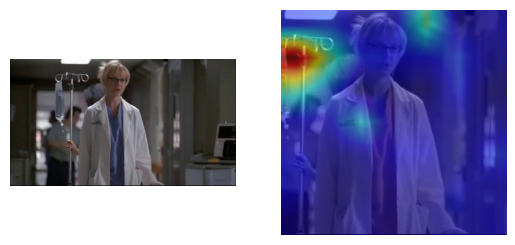

CLIP similarity score: 0.017303466796875
tensor([0.4958, 0.1604, 0.0491, 0.2949], device='cuda:0', dtype=torch.float16)


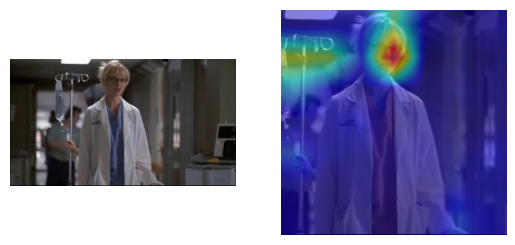

CLIP similarity score: 0.0028247833251953125
tensor([0.4922, 0.2084, 0.1145, 0.1851], device='cuda:0', dtype=torch.float16)


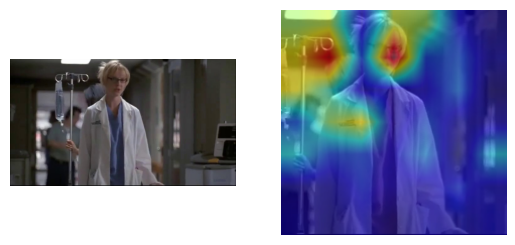

CLIP similarity score: 0.00710296630859375
tensor([0.6465, 0.2184, 0.0381, 0.0971], device='cuda:0', dtype=torch.float16)


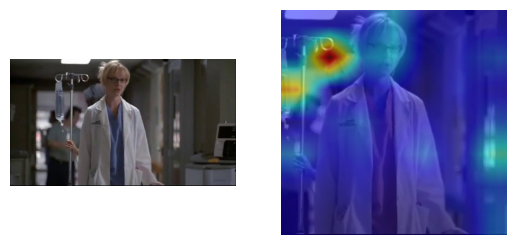

CLIP similarity score: 0.0130615234375
tensor([0.5449, 0.1078, 0.0447, 0.3027], device='cuda:0', dtype=torch.float16)


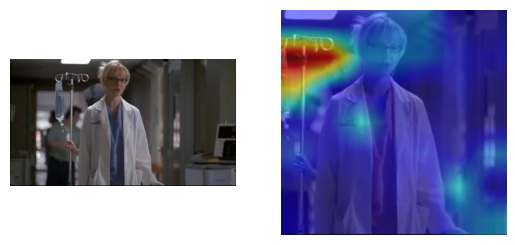

In [36]:
img_path = "/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/grey_s01e01_seg02_clip_09.mp4/frame_000049.jpg"
image_input = preprocess(Image.open(img_path).convert("RGB"))
img = image_input.unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a school", "This is a outside", "This is a home"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
probs = logits_per_image.softmax(dim=-1)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print("medical TV show predicted as medical video")
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()


[[0.4167  0.5107  0.02748 0.01404 0.03114]]
CLIP similarity score: 0.416748046875
tensor([0.5166, 0.3762, 0.1075, 0.0000], device='cuda:0', dtype=torch.float16)


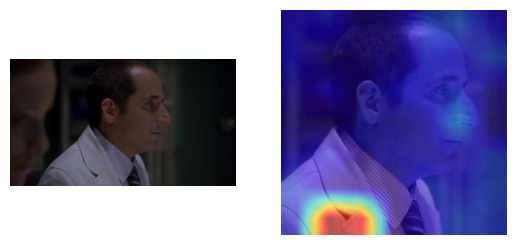

CLIP similarity score: 0.5107421875
tensor([0.2104, 0.0845, 0.0219, 0.6831], device='cuda:0', dtype=torch.float16)


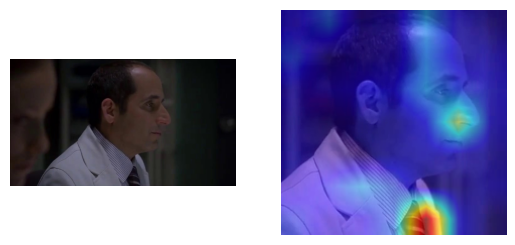

CLIP similarity score: 0.0274810791015625
tensor([0.4080, 0.0919, 0.0778, 0.4221], device='cuda:0', dtype=torch.float16)


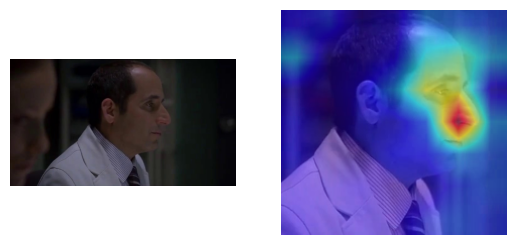

CLIP similarity score: 0.0140380859375
tensor([0.3149, 0.1652, 0.1109, 0.4092], device='cuda:0', dtype=torch.float16)


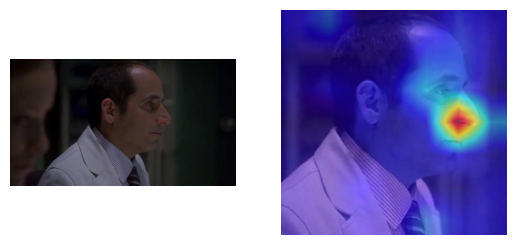

CLIP similarity score: 0.0311431884765625
tensor([0.5840, 0.2257, 0.0917, 0.0987], device='cuda:0', dtype=torch.float16)


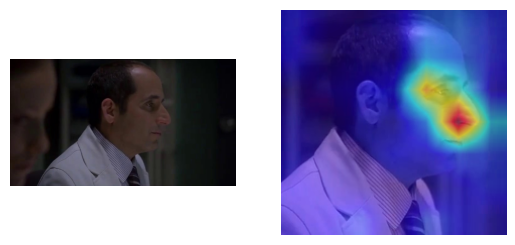

In [25]:
img_path = '/home/hlpark/REDUCE/REDUCE_benchmarks/HiREST/data/splits/tvqa/raw_frames/house_s05e16_seg02_clip_02.mp4/frame_000061.jpg'
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["This is a hospital", "This is a office", "This is a home", "This is a school", "This is a outside"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
with torch.no_grad():
  probs = logits_per_image.softmax(dim=-1).cpu().numpy()
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
print(probs)
for i in range(batch_size):
  print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {probs[0][i].item()}' + color.END)
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()